In [1]:
from fastai.vision.all import *

In [2]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")

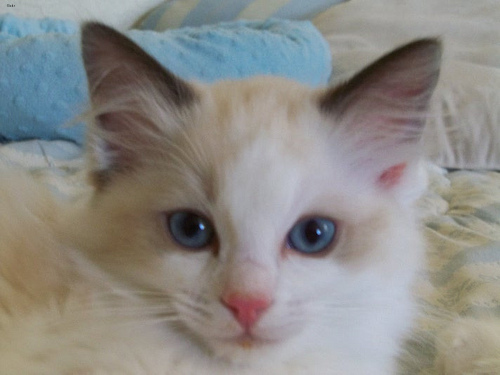

In [3]:
img = PILImage.create(items[0])
img

In [4]:
from albumentations import ShiftScaleRotate

In [5]:
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

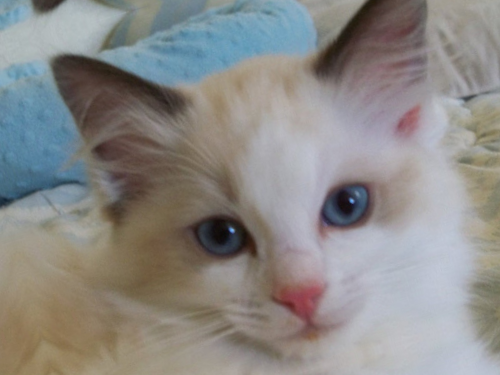

In [6]:
aug_tfm(img)

In [7]:
tfm = Transform(aug_tfm)

In [8]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

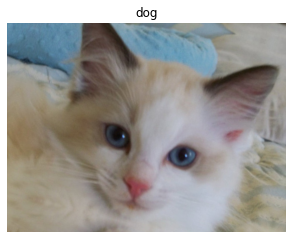

In [9]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, 'dog'))
show_image(a, title=b);

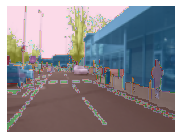

In [10]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show()
ax = mask.show(ctx=ax)

In [11]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

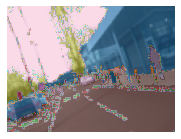

In [12]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, mask))
ax = a.show()
ax = b.show(ctx=ax)

In [13]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [14]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

In [15]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

/home/ec2-user/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [16]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [17]:
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))])

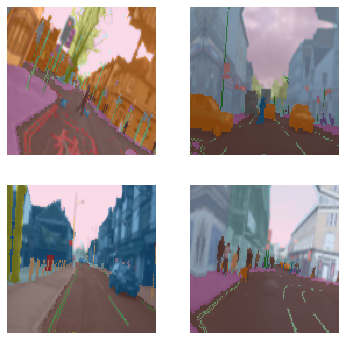

In [18]:
dls.show_batch(max_n=4)

In [19]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [22]:
import albumentations

In [23]:
def get_train_aug(): return albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

In [24]:
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug())]

/home/ec2-user/anaconda3/envs/fastai/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [25]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=item_tfms)

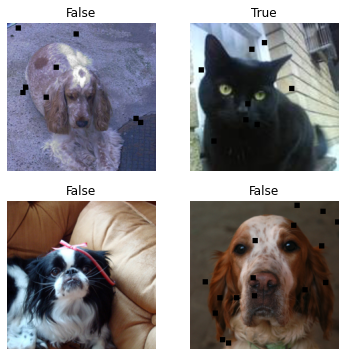

In [26]:
dls.train.show_batch(max_n=4)

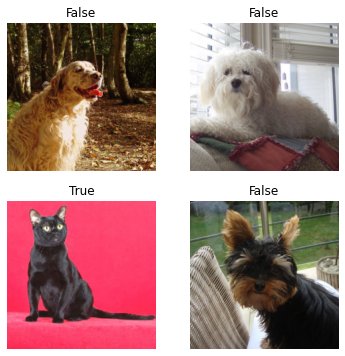

In [27]:
dls.valid.show_batch(max_n=4)

In [28]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [29]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224)
], p=1.)

In [30]:
item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(), get_valid_aug())]

In [31]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=item_tfms)

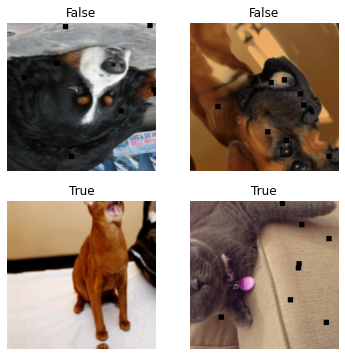

In [32]:
dls.train.show_batch(max_n=4)

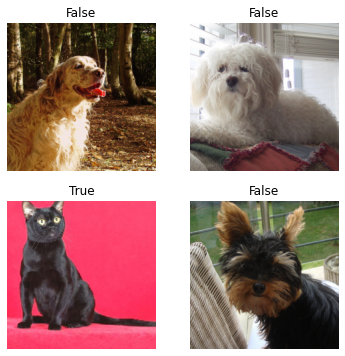

In [33]:
dls.valid.show_batch(max_n=4)

In [34]:
x,_ = dls.valid.one_batch()
print(x.shape)

torch.Size([64, 3, 224, 224])


In [ ]:
################ image location

In [36]:
from fastai.data.all import *
from fastai.vision.all import *

In [37]:
path = untar_data(URLs.CAMVID_TINY)

In [50]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

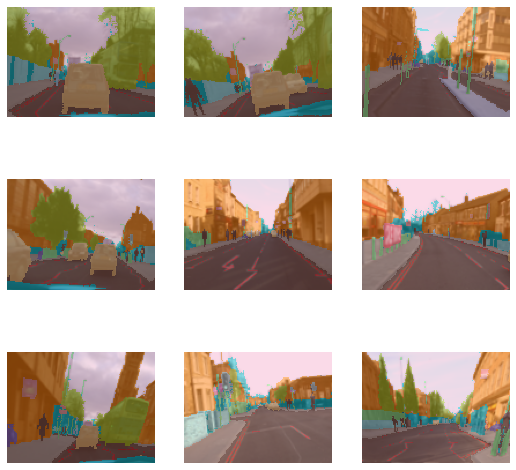

In [51]:
dls = camvid.dataloaders(path/"images")
dls.show_batch() ## object

In [41]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = load_pickle(biwi_source/'centers.pkl')

In [43]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

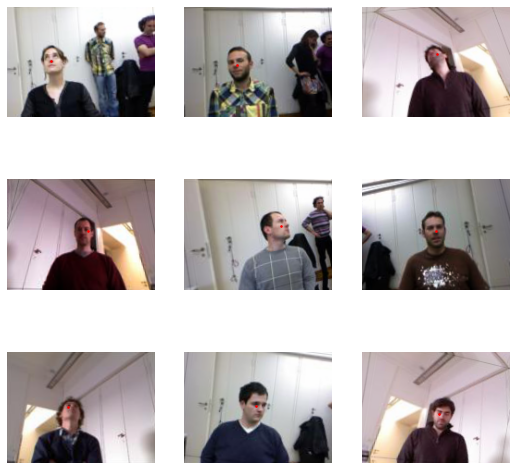

In [44]:
dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9) #point

In [46]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox)) ## box

In [48]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

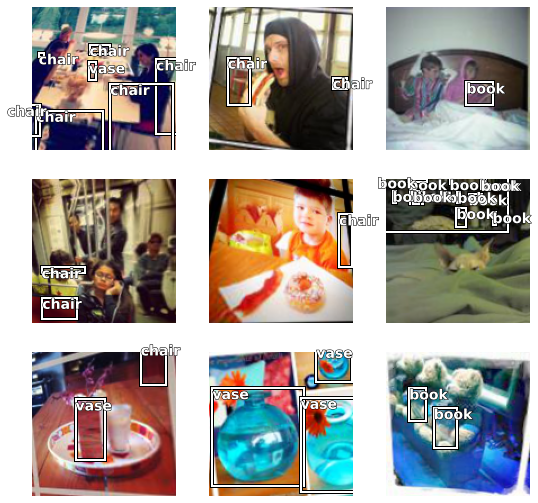

In [49]:
dls = coco.dataloaders(coco_source)
dls.show_batch(max_n=9)
